# University of Maryland: Fearless Leaders or Fearless Criminals?

Jessica Hatfield and Nate Ostrander<br/>
CMSC320 Fall 2017

# Assessing arrest data

All of us have received the infamous <a href="https://alert.umd.edu/">UMD Alerts</a> notifying us of the latest theft, burglary, or assault. However, we rarely find out when arrests are made. The purpose of this project is to assess arrest data from the <a href="http://www.umpd.umd.edu/">University of Maryland Police Department</a> and identify patterns over time. We chose to use UMD arrest data because, as students at the University of Maryland, we think that it is important to understand crime on campus.

<h2>Table of contents</h2>

The data lifecycle was an important, recurring element of our class; therefore, we will structure our tutorial around the steps of the data lifecycle.

<ul>
    <li><a href="#Getting-started">Getting started</a></li>
    <li><a href="#Data-collection-and-processing">Data collection and processing</a>
        <ul>
            <li><a href="#Collection">Collection</a></li>
            <li><a href="#Processing">Processing</a></li>
        </ul>
    </li>
    <li><a href="#Exploratory-data-analysis-and-visualization">Exploratory data analysis and visualization</a>
        <ul>
            <li><a href="#Plotting-by-time">Plotting by time</a></li>
            <li><a href="#Plotting-by-offense-type">Plotting by offense type</a></li>
            <li><a href="#Plotting-by-time-and-offense-type">Plotting by time and offense type</a></li>
        </ul>
    </li>
    <li><a href="#Analysis-and-hypothesis-testing">Analysis and hypothesis testing</a>
        <ul>
            <li><a href="#Preparing-the-dataframe">Preparing the dataframe</a></li>
            <li><a href="#Rejecting-the-null-hypothesis">Rejecting the null hypothesis</a></li>
            <li><a href="#Logistic-regression">Logistic regression</a></li>
            <li><a href="#10-fold-cross-validation">10-fold cross validation</a></li>
            <li><a href="#Confusion-matrix">Confusion matrix</a></li>
        </ul>
    </li>
    <li><a href="#Insight">Insight</a></li>
</ul>

# Getting started

We will be using <a href="https://www.python.org/downloads/release/python-350/">`Python3.5`</a> as well as the following `python` libraries:
<ul>
    <li><a href="https://www.crummy.com/software/BeautifulSoup/">`BeautifulSoup`</a></li>
    <li><a href="http://docs.python-requests.org/en/master/">`requests`</a></li>
    <li><a href="https://pandas.pydata.org/">`pandas`</a></li>
    <li><a href="http://www.numpy.org/">`numpy`</a></li>
    <li><a href="https://matplotlib.org/index.html">`matplotlib`</a></li>
    <li><a href="https://seaborn.pydata.org/">`seaborn`</a></li>
    <li><a href="http://scikit-learn.org/stable/">`sklearn`</a></li>
    <li><a href="http://www.statsmodels.org/stable/index.html">`statsmodels`</a></li>
</ul>

Below is the code to import the necessary libraries.

In [2]:
from bs4 import BeautifulSoup

import requests as req
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm

# Data collection and processing

We are getting our data from the <a href="http://www.umpd.umd.edu/stats/arrest_report.cfm">University of Maryland Police Department's Crime Stats</a> website. We are using the arrest data for the past seven years, i.e. from 2010 to 2017, because the data from the years 2006 to 2009 is not available. It is important to note that the UMPD updates their arrest data every day, so the data for 2017 will change as the semester progresses.

<h2>Collection</h2>

To collect the data from the webpage, we are using the python `requests` and `BeautifulSoup` libraries and storing the data in a `pandas dataframe`. Below is an example of UMPD arrest data from 2010. As you can see, because the HTML table contains `rowspans` and `colspans`, information corresponding to each arrest record is spread out across two rows of the `dataframe`. We cannot make any reasonable analyses with the data in this form; therefore, we need to process it more.

In [3]:
r = req.get('http://www.umpd.umd.edu/stats/arrest_report.cfm?year=2010')
text = r.text
soup = BeautifulSoup(text, 'html.parser')
table = soup.find('table')
df = pd.read_html(str(table), flavor='bs4')[0]
df.head()

,0,1,2,3,4,5
0,ARRESTNUMBER,ARRESTED DATE TIMECHARGE,UMPD CASE NUMBER,AGE,RACE,SEX
1,16001,11/09/10 23:30,2010-00000115,NaN,Black,Male
2,CDS: Possess Paraphernalia,NaN,NaN,NaN,NaN,NaN
3,16002,11/10/10 00:20,2010-00000126,NaN,Black,Male
4,"Theft: $1,000 to Under $10,000",NaN,NaN,NaN,NaN,NaN


<h2>Processing</h2>

Next, we need to clean up and process the data. The problems resulting from `rowspans` and `colpans` are solved by moving the decription from the second row of the corresponding arrest record's data into a `description` column in the first row and removing the second row completely. Additionally, a `year` column is added to the dataframe for easy access to each year's data. After individual `dataframes` are created for each year from 2010 to 2017, they are concatenated together to form one large `dataframe` that contains the arrest data for every year from 2010 to 2017.

In [4]:
frames = []

# Have to make separate requests for every year
for i in range(2010, 2018):

    # Putting the data into a dataframe
    r = req.get('http://www.umpd.umd.edu/stats/arrest_report.cfm?year=' + str(i))
    text = r.text
    soup = BeautifulSoup(text, 'html.parser')
    table = soup.find('table')
    df = pd.read_html(str(table), flavor='bs4')[0]
    
    df.drop(df.index[:1], inplace=True)
    df.columns = ['arrest_number', 'date_time', 'case_number', 'age', 'race', 'gender']
    df['description'] = ''
    df['year'] = 0
    
    # Fixing issues caused by the row and colspans
    for index in range(1, df.shape[0]):
        descr = df.get_value(index + 1, 'arrest_number')
        df.set_value(index, 'description', descr)
        df.set_value(index, 'year', i)
    
    # Removing every other row
    df = df.iloc[::2]
    
    # Adding current df to the list of dataframes
    frames.append(df)

# Combining individual dataframes
dataframe = pd.concat(frames)
dataframe.reset_index(inplace=True, drop=True)

dataframe.head()

,arrest_number,date_time,case_number,age,race,gender,description,year
0,16001,11/09/10 23:30,2010-00000115,NaN,Black,Male,CDS: Possess Paraphernalia,2010
1,16002,11/10/10 00:20,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010
2,16003,11/10/10 00:20,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010
3,16005,11/10/10 22:44,2010-00000292,NaN,White,Male,"(Driving, Attempting to drive) veh. while unde...",2010
4,16006,11/11/10 17:54,2010-00000414,NaN,White,Male,"(Driving, Attempting to drive) motor veh. on h...",2010


Next, the values from the `date_time` column are converted into `python` `datetime` objects.

In [5]:
# Changing everything in the date_time column to python datetime objects
for index, row in dataframe.iterrows():
    date = dataframe.get_value(index, 'date_time').split(' ')[0].split('/')
    time = dataframe.get_value(index, 'date_time').split(' ')[1].split(':')
    dt = datetime.datetime(int(date[2]) + 2000, int(date[0]), int(date[1]), int(time[0]), int(time[1]))
    dataframe.set_value(index, 'date_time', dt)
    
dataframe.head()

,arrest_number,date_time,case_number,age,race,gender,description,year
0,16001,2010-11-09 23:30:00,2010-00000115,NaN,Black,Male,CDS: Possess Paraphernalia,2010
1,16002,2010-11-10 00:20:00,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010
2,16003,2010-11-10 00:20:00,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010
3,16005,2010-11-10 22:44:00,2010-00000292,NaN,White,Male,"(Driving, Attempting to drive) veh. while unde...",2010
4,16006,2010-11-11 17:54:00,2010-00000414,NaN,White,Male,"(Driving, Attempting to drive) motor veh. on h...",2010


After the data is properly organized, our next goal is to categorize the descriptions by type of incident. We are removing all rows that have an `NaN` `description` becasue we feel that if the incident was not properly reported, we will not be able to draw any conclusions from it.

In [6]:
dataframe = dataframe.dropna(subset=['description'])

# Finding all unique descriptions
crimes = dataframe.groupby('description')

print('Number of unique crimes: ' + str(len(crimes)))

Number of unique crimes: 911


It is apparent that there are far too many incident types when we attempt to group by `description` alone. Most of these "unique" descriptions describe the same type of incident as well. To solve this problem, we are going to define `incident_types` as a list of crime descriptors that appear multiple times in the `description` column. With these `incident_types`, we will be able to generalize the offense of each incident by looking for keywords in the `description`.

In [7]:
# Keywords to search for
incident_types = ['suspicion', 'false government identification', 'revoked lic.', 'driving', 'w/o req. license and authorization', 'alcohol', 'urinating','drug', 'suspended lic', 'disorderly conduct', 'fictitious lic', 'trespass', 'theft', 'marijuana', 'rogue and vagabond', 'robbery', 'rape', 'resist', 'molest', 'obstructing and hindering', 'destruction property', 'handgun', 'murder', 'assault', 'burglary', 'cds', 'controlled dangerous substance', 'credit card', 'deadly weapon', 'false documentation']

# credic card = theft
# suspended lic + fictitious lic = false documentation
# CDS = controled dangerous substance
# Rogue and Vagabond = breaking and entering vehicle

# Map of keywords to offenses
offense_types = {'suspicion': 'Suspicious Activity', 'alcohol': 'Alcohol Related', 'Missing Proper Documentation': 'Missing Proper Documentation', 'DUI': 'DUI', 'urinating': 'Public Urination', 'drug': 'Drug Related', 'disorderly conduct': 'Disorderly Conduct', 'fictitious lic': 'False Documentation', 'trespass': "Trespassing", 'theft': 'Theft', 'marijuana': 'Marijuana', 'rogue and vagabond': 'Rogue and Vagabond', 'robbery': 'Robbery', 'rape': 'Rape', 'resist': 'Resisting Arrest', 'molest': 'Molestation', 'obstructing and hindering': 'Obstructing and Hindering', 'destruction property': 'Destruction of Property', 'handgun': 'Illegal Possession of Handgun', 'murder': 'Murder', 'assault': 'Assault', 'burglary': 'Burglary', 'controlled dangerous substance': 'Controled Dangerous Substance', 'cds': 'Controled Dangerous Substance', 'credit card': 'Theft', 'deadly weapon': 'Concealed Deadly Weapon', 'false documentation': 'False Documentation'}

# Map to keep track of the number of each offense
num_offenses = {'Suspicious Activity': 0, 'Missing Proper Documentation': 0, 'DUI': 0, 'Alcohol Related': 0, 'Public Urination': 0, 'Controled Dangerous Substance': 0, 'Drug Related': 0, 'Disorderly Conduct': 0, 'Trespassing': 0, 'Marijuana': 0, 'Rogue and Vagabond': 0, 'Robbery': 0, 'Rape': 0, 'Resisting Arrest': 0, 'Molestation': 0, 'Obstructing and Hindering': 0, 'Destruction of Property': 0, 'Illegal Possession of Handgun': 0, 'Murder': 0, 'Assault': 0, 'Burglary': 0, 'Theft': 0, 'Concealed Deadly Weapon': 0, 'False Documentation': 0}

dataframe['offense_types'] = None

for index, row in dataframe.iterrows():
    
    # Getting list of keywords present in current description
    result = list(filter(lambda x: x if x in row['description'].lower() else "", incident_types))
    
    if 'false government identification' in result:
        result.remove('false government identification')
        result.append('false documentation')
    if 'revoked lic.' in result:
        result.remove('revoked lic.')
        result.append('Missing Proper Documentation')
    if 'suspended out of state lic.' in result:
        result.remove('suspended out of state lic.')
        result.append('Missing Proper Documentation')
    if 'driving' in result and 'alcohol' in result:
        result.remove('alcohol')
        result.append('DUI')
    if 'driving' in result and 'w/o req. license and authorization' in result:
        result.remove('w/o req. license and authorization')
        result.append('Missing Proper Documentation')
    if 'driving' in result and 'suspended lic' in result:
        result.remove('suspended lic')
        result.append('Missing Proper Documentation')
    if 'driving' in result:
        result.remove('driving')

    for i, offense in enumerate(result):
        result[i] = offense_types[offense]
        num_offenses[result[i]]+= 1
    dataframe.set_value(index, 'offense_types', result)

dataframe.head()

,arrest_number,date_time,case_number,age,race,gender,description,year,offense_types
0,16001,2010-11-09 23:30:00,2010-00000115,NaN,Black,Male,CDS: Possess Paraphernalia,2010,[Controled Dangerous Substance]
1,16002,2010-11-10 00:20:00,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010,[Theft]
2,16003,2010-11-10 00:20:00,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010,[Theft]
3,16005,2010-11-10 22:44:00,2010-00000292,NaN,White,Male,"(Driving, Attempting to drive) veh. while unde...",2010,[DUI]
4,16006,2010-11-11 17:54:00,2010-00000414,NaN,White,Male,"(Driving, Attempting to drive) motor veh. on h...",2010,[Missing Proper Documentation]


Finally, our data is collected and clean!

# Exploratory data analysis and visualization

Before declaring a hypothesis, we want to understand our data better by visualizing it. First, we will plot the number of arrests against different units of time, such as year, month, day of the week, and hour of the day. Then, we will plot the number of incident types. Finally we will combine the two to see if certain types of arrests are more likely to occur in specific years, month, days, or hours. We are using `matplotlib.pyplot` to create our plots.

<h2>Plotting by time</h2>

First, we will plot the number of arrests against year, month, day, and hour.

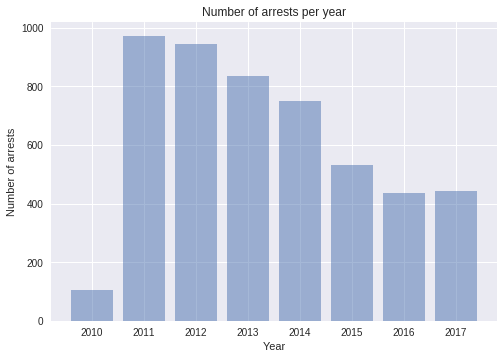

In [8]:
# Plotting by year

plt.close('all')

plt.title('Number of arrests per year')
plt.ylabel('Number of arrests')
plt.xlabel('Year')

num_arrests = []
for i in range(2010, 2018):
    num_arrests.append(len(dataframe.query('year == @i')))

plt.bar(range(2010, 2018), num_arrests, align='center', alpha=0.5)

plt.show()

With the exception of 2010, it seems clear from the plot above that the number of arrests at the University of Maryland has decreased since 2011. The discrepancy in 2010 could be due to faulty record keeping by the UMPD. Additionally, this plot could serve as a basis to the claim that crime has decreased at UMD over the past 6 years.

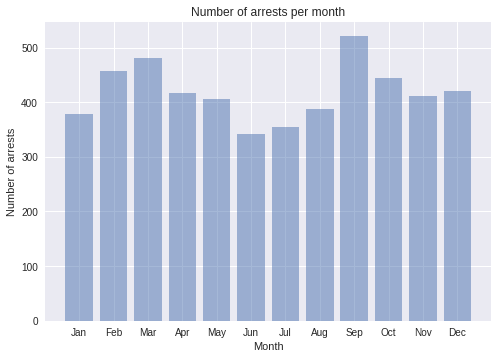

In [9]:
# Plotting by month

plt.close('all')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.title('Number of arrests per month')
plt.ylabel('Number of arrests')
plt.xlabel('Month')
plt.xticks(range(1,13), months)

num_arrests = [0]*12
for index, row in dataframe.iterrows():
    month = dataframe.get_value(index, 'date_time').month
    num_arrests[month - 1] += 1
    
plt.bar(range(1,13), num_arrests, align='center', alpha=0.5)

plt.show()

Because a majority of the students attending the University of Maryland are present on campus from September to May, the drop in number of arrests over the summer in this plot is unsuprising. What is interesting to note; however, is that the highest number of arrests occur in September. This could be due to the increased number of parties during syllabus week and the start of football tailgating season.

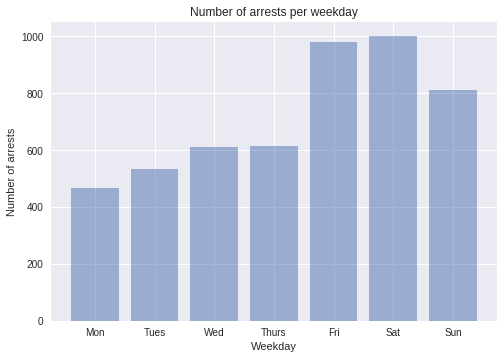

In [10]:
# Plotting by weekday

plt.close('all')

weekdays = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

plt.title('Number of arrests per weekday')
plt.ylabel('Number of arrests')
plt.xlabel('Weekday')
plt.xticks(range(7), weekdays)

num_arrests = [0]*7
for index, row in dataframe.iterrows():
    weekday = dataframe.get_value(index, 'date_time').weekday()
    num_arrests[weekday] += 1
    
plt.bar(range(7), num_arrests, align='center', alpha=0.5)

plt.show()

As expected in a college town, the number of arrests at UMD is the highest on Fridays, Saturdays, and Sundays. This could be due to the fact that many college students go to bars or parties to drink on the weekends. However, it is important to note that this plot does not distinguish between types of arrests; therefore, it is unclear if most of the arrests on the weekends are alcohol related. 

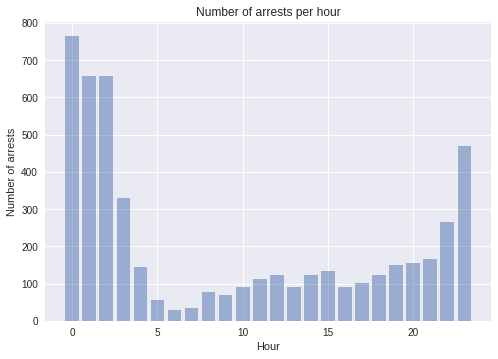

In [11]:
# Plotting by hour where 0 is 00:00, 5 is 05:00, and so on

plt.close('all')

plt.title('Number of arrests per hour')
plt.ylabel('Number of arrests')
plt.xlabel('Hour')

num_arrests = [0]*24
for index, row in dataframe.iterrows():
    hour = dataframe.get_value(index, 'date_time').hour
    num_arrests[hour] += 1

plt.bar(range(0, 24), num_arrests, align='center', alpha=0.5)

plt.show()

Before creating this plot, we could have guessed that most arrests occur late at night and in the early hours of the morning based on our previous knowledge of when crime is most likely to happen. After creating this plot, it is clear that this is true because the highest number of arrests occur between 23:00 and 03:00.

<h2>Plotting by offense type</h2>

Next, we will plot the occurrences of each offense grabbed from the arrest description. The number of offenses will be larger than the number of arrests because there can be multiple offenses for a single arrest.


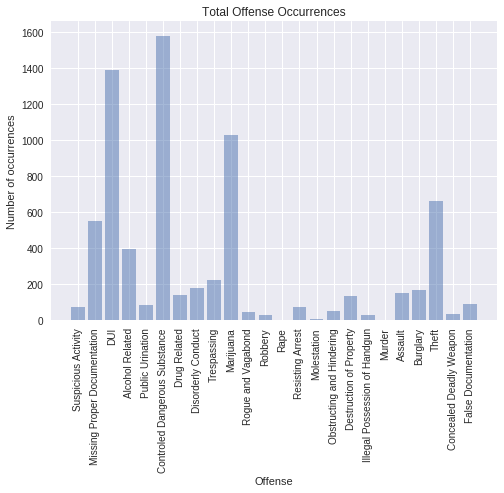

In [12]:
plt.close('all')

plt.title('Total Offense Occurrences')
plt.ylabel('Number of occurrences')
plt.xlabel('Offense')

plt.bar(range(len(num_offenses)), num_offenses.values(), align='center', alpha=0.5)
plt.xticks(range(len(num_offenses)), num_offenses.keys(), rotation='vertical')
plt.show()

From this plot, we can see that `CDS`, `DUI`, and `Marijuana` arrests make up the majority of arrests at the University of Maryland.

<h2>Plotting by time and offense type</h2> 

Finally, we will put it all together by plotting the offense breakdown over years, months, weekdays, and hours. Because we are interested in the relationship between the number of alcohol related arrests and time, we will pay close attention to the number of `DUI` and `Alcohol Related` arrests in the following plots.

In [13]:
# Designating a specific color for each offense type
offense_colors = cm.gist_ncar(np.linspace(0, 1, len(num_offenses)))

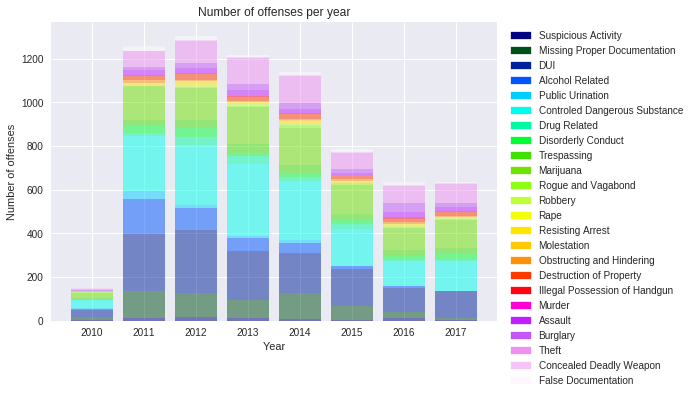

In [14]:
# Creating a plot breaking down the offense type for each year over the 7 year period
plt.close('all')

year_offenses = {}

for offense_name in list(num_offenses.keys()):
    year_offenses[offense_name] = []
    for i in range(0,8):
        year_offenses[offense_name].append(0)
    
fig, ax = plt.subplots()
plt.title('Number of offenses per year')
plt.ylabel('Number of offenses')
plt.xlabel('Year')

color = 0
for index, row in dataframe.iterrows():
    for offense in row['offense_types']:
        year_offenses[offense][row['date_time'].year-2010]+= 1
        
legend = []
for offense in num_offenses.keys():
    if(color == 0):
        plt.bar(range(2010,2018), year_offenses[offense], align='center', alpha=0.5, color = cm.colors.to_hex(offense_colors[color]))
        prev = np.array(year_offenses[offense])
    else:
        plt.bar(range(2010,2018), year_offenses[offense], align='center', alpha=0.5, color = cm.colors.to_hex(offense_colors[color]), bottom=prev)
        prev = prev + np.array(year_offenses[offense])    
    legend.append(mpatches.Patch(color=cm.colors.to_hex(offense_colors[color]), label=offense))
    color += 1

plt.legend(handles=legend, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

As the number of total arrests has decreased, the number of total `DUI` and `Alcohol Related` arrests has decreased as well. However, `Alcohol Related` arrests have decreased much more quickly than `DUI` arrests.

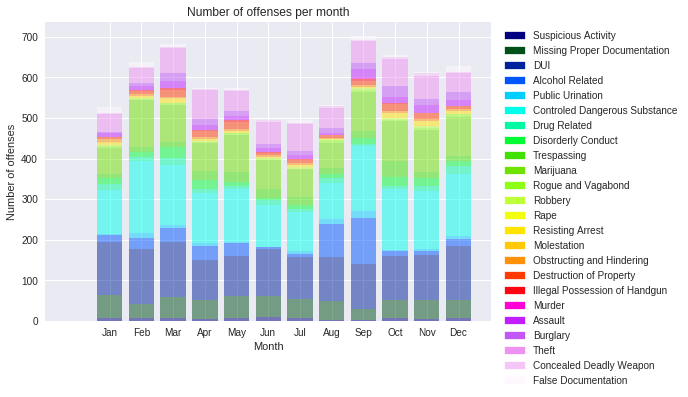

In [15]:
# Creating a plot breaking down the offense type for each month of the year
plt.close('all')

month_offenses = {}

for offense_name in list(num_offenses.keys()):
    month_offenses[offense_name] = []
    for i in range(13):
        month_offenses[offense_name].append(0)

        
fig, ax = plt.subplots()
plt.title('Number of offenses per month')
plt.ylabel('Number of offenses')
plt.xlabel('Month')
plt.xticks(range(1,13), months)

color = 0
for index, row in dataframe.iterrows():
    for offense in row['offense_types']:
        month_offenses[offense][row['date_time'].month]+= 1
        
legend = []
for offense in num_offenses.keys():
    if(color == 0):
        plt.bar(range(0,13), month_offenses[offense], align='center', alpha=0.5, color = cm.colors.to_hex(offense_colors[color]))
        prev = np.array(month_offenses[offense])
    else:
        plt.bar(range(0,13), month_offenses[offense], align='center', alpha=0.5, color = cm.colors.to_hex(offense_colors[color]), bottom=prev)
        prev = prev + np.array(month_offenses[offense])    
    legend.append(mpatches.Patch(color=cm.colors.to_hex(offense_colors[color]), label=offense))
    color += 1

plt.legend(handles=legend, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

Previously, we predicted that the spike in September arrests may be due to students returning to campus and attending parties and tailgates. From this plot, we can tell that the number of alcohol related arrests is the greatest in September, which validates our claim.

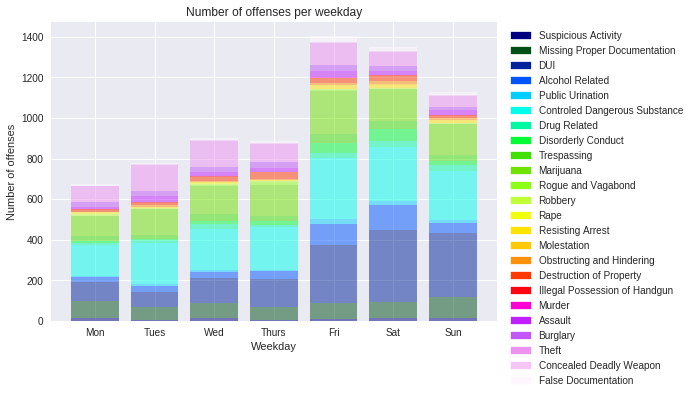

In [16]:
# Creating a plot breaking down the offense type for each day of the week
plt.close('all')

day_offenses = {}

for offense_name in list(num_offenses.keys()):
    day_offenses[offense_name] = []
    for i in range(0,7):
        day_offenses[offense_name].append(0)
    
fig, ax = plt.subplots()

plt.title('Number of offenses per weekday')
plt.ylabel('Number of offenses')
plt.xlabel('Weekday')
plt.xticks(range(7), weekdays)

color = 0
for index, row in dataframe.iterrows():
    for offense in row['offense_types']:
        day_offenses[offense][row['date_time'].weekday()]+= 1
        
legend = []
for offense in num_offenses.keys():
    if(color == 0):
        plt.bar(range(0,7), day_offenses[offense], align='center', alpha=0.5, color = cm.colors.to_hex(offense_colors[color]))
        prev = np.array(day_offenses[offense])
    else:
        plt.bar(range(0,7), day_offenses[offense], align='center', alpha=0.5, color = cm.colors.to_hex(offense_colors[color]), bottom=prev)
        prev = prev + np.array(day_offenses[offense])    
    legend.append(mpatches.Patch(color=cm.colors.to_hex(offense_colors[color]), label=offense))
    color += 1

plt.legend(handles=legend, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

In the plot of number of arrests per weekday above, we noted that the increased number of arrests over the weekend was likely due to an increased number of alcohol related arrests. In this plot, we can see that the number of `DUI` and `Alcohol Related` arrests spike on Fridays, Saturdays, and Sundays. This observation validates our initial statement.

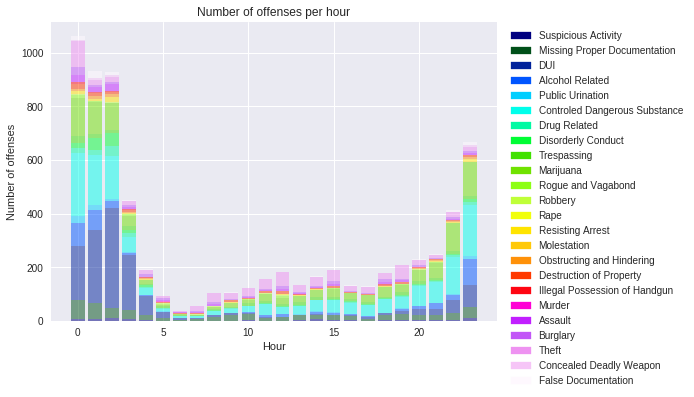

In [17]:
# Creating a plot breaking down the offense type for each hour of the day
plt.close('all')

hour_offenses = {}

for offense_name in list(num_offenses.keys()):
    hour_offenses[offense_name] = []
    for i in range(24):
        hour_offenses[offense_name].append(0)
    
fig, ax = plt.subplots()
plt.title('Number of offenses per hour')
plt.ylabel('Number of offenses')
plt.xlabel('Hour')
color = 0
for index, row in dataframe.iterrows():
    for offense in row['offense_types']:
        hour_offenses[offense][row['date_time'].hour]+= 1

legend = []
for offense in num_offenses.keys():
    if(color == 0):
        plt.bar(range(0,24), hour_offenses[offense], align='center', alpha=0.5, color = cm.colors.to_hex(offense_colors[color]))
        prev = np.array(hour_offenses[offense])
    else:
        plt.bar(range(0,24), hour_offenses[offense], align='center', alpha=0.5, color = cm.colors.to_hex(offense_colors[color]), bottom=prev)
        prev = prev + np.array(hour_offenses[offense])    
    legend.append(mpatches.Patch(color=cm.colors.to_hex(offense_colors[color]), label=offense))
    color += 1

plt.legend(handles=legend, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

When looking at the number of offenses per hour plot, it is interesting to note that non-driving `Alcohol Related` arrests peak at 11pm and decrease until 3am. Conversely, `DUI` charges begin to increase around 11pm and continue to increase drastically until 3am. It is possible that this inverse relationship is a result of officers attempting to prevent possible DUIs.

From the time vs. offense type graphs above, we can conclude that DUI and Alcohol Related arrests are not only a huge concern for the University of Maryland Police Department, but they are influenced by year, month, weekday, and hour. Furthermore, we believe that we can predict whether or not an arrest is a `DUI` or `Alcohol Related` based on the `year`, `month`, `weekday`, and `hour` of its occurrence. To prove this relationship; however, we will need to reject a null hypothesis and properly analyze our results.

# Analysis and hypothesis testing

In this section, we will attempt to prove that the number of alcohol related arrests is influenced by time. In other words, we would like to see if the independent variables `year`, `month`, `weekday`, and `hour` can be used to predict if an arrest was alcohol related or not. More information about the steps taken in our analysis can be found <a href="https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8">here</a>.

<strong>Null hypothesis:</strong> The number of alcohol related arrests, categorized by `DUI` and `Alcohol Related`, <em>is not</em> dependent on time, categorized by `year`, `month`, `weekday`, and `hour`.

<strong>Alternative hypothesis:</strong> The number of alcohol related arrests, categorized by `DUI` and `Alcohol Related`, <em>is</em> influenced by time, categorized by `year`, `month`, `weekday`, and `hour`.

<h2>Preparing the dataframe</h2>

To make our analysis easier, we will first add columns to our `dataframe` representing `month`, `weekday`, `hour`, and whether or not the `offense_type` contains `DUI` or `Alcohol Related`.

In [18]:
dataframe['month'] = -1   #1-12
dataframe['weekday'] = -1 #0-6
dataframe['hour'] = -1    #0-23
dataframe['alcohol'] = False

for index, row in dataframe.iterrows():
    month = dataframe.get_value(index, 'date_time').month 
    weekday = dataframe.get_value(index, 'date_time').weekday() 
    hour = dataframe.get_value(index, 'date_time').hour
    dataframe.set_value(index, 'month', month)
    dataframe.set_value(index, 'weekday', weekday)
    dataframe.set_value(index, 'hour', hour)
    
    offenses = dataframe.get_value(index, 'offense_types')
    if 'Alcohol Related' in offenses or 'DUI' in offenses:
        dataframe.set_value(index, 'alcohol', True)
    
dataframe.head()

,arrest_number,date_time,case_number,age,race,gender,description,year,offense_types,month,weekday,hour,alcohol
0,16001,2010-11-09 23:30:00,2010-00000115,NaN,Black,Male,CDS: Possess Paraphernalia,2010,[Controled Dangerous Substance],11,1,23,False
1,16002,2010-11-10 00:20:00,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010,[Theft],11,2,0,False
2,16003,2010-11-10 00:20:00,2010-00000126,NaN,Black,Male,"Theft: $1,000 to Under $10,000",2010,[Theft],11,2,0,False
3,16005,2010-11-10 22:44:00,2010-00000292,NaN,White,Male,"(Driving, Attempting to drive) veh. while unde...",2010,[DUI],11,2,22,True
4,16006,2010-11-11 17:54:00,2010-00000414,NaN,White,Male,"(Driving, Attempting to drive) motor veh. on h...",2010,[Missing Proper Documentation],11,3,17,False


In [22]:
# For the remaining analyses we define:
X = dataframe[['year', 'month', 'weekday', 'hour']]
y = dataframe['alcohol']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

<h2>Rejecting the null hypothesis</h2>

Before fitting our model, we are going to check the p-values of our independent variables to see if they are statically significant so that we can reject the null hypothesis.

In [23]:
logit_model = sm.Logit(y,X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.606067
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                alcohol   No. Observations:                 5020
Model:                          Logit   Df Residuals:                     5016
Method:                           MLE   Df Model:                            3
Date:                Sat, 16 Dec 2017   Pseudo R-squ.:                 0.06844
Time:                        04:13:56   Log-Likelihood:                -3042.5
converged:                       True   LL-Null:                       -3266.0
                                        LLR p-value:                 1.418e-96
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year          -0.0004   4.75e-05     -7.652      0.000      -0.000      -0.000
month         -0.0068      0.

In the summary table above, we can see that the p-values of most of the variables are less than 0.05, which means that most of our independent variables will be significant to the model. We can now reject the null hypothesis!

<h2>Logistic regression</h2>

We are choosing to use a logistic regression for our analysis because our hypothesis is a classification problem, i.e. an arrest is either alcohol related or not. Our logistic regression is multivariate because we want to include all factors of time: `year`, `month`, `weekday`, and `hour`.

In [19]:
regr = LogisticRegression()
regr.fit(X_train, y_train)

print('Logistic regression score: %.3f' % regr.score(X_test, y_test))

Logistic regression score: 0.677


After fitting our linear regression, we get a score of about 68%. This is pretty good because it means that, according to our regression, there is a 68% chance that alcohol related arrests are related to year, month, weekday, and hour.

<h2>10-fold cross validation</h2>

Now, we want to train our model with 10-fold cross validation.

In [113]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)

print('10-fold cross validation average accuracy: %.3f' % (results.mean()))

10-fold cross validation average accuracy: 0.671


The average acuracy of our 10-fold cross validation is about 67%, which is very close to the score obtained by our logistic regression, which was about 68%. This means that our model generalizes well.

<h2>Confusion matrix</h2>

Finally we will use a confusion matrix to get the number of correct and incorrect predictions made by our model.

In [24]:
y_pred = regr.predict(X_test)
matrix = confusion_matrix(list(y_test.values), list(y_pred))
print(matrix)
print('Correct predictions: %d' % (matrix[0][0] + matrix[1][1]))
print('Incorrect predicitons: %d' % (matrix[0][1] + matrix[1][0]))

[[860 126]
 [360 160]]
Correct predictions: 1020
Incorrect predicitons: 486


We find that the number of correct predictions (`matrix[0][0] + matrix[1][1]`) is 1020 and the number of incorrect predictions (`matrix[0][1] + matrix[1][0]`) is 486. About 68% of our predictions were correct, which is consistent with the score from our logistic regression model.

Based on the above analyses and our rejection of the null hypothesis, we can now accept our alternative hypothesis and say that there is a relationship between the number of alcohol related arrests and time.

# Insight

In conclusion, we sought to learn general information about arrest data at the University of Maryland, and ended up proving that there is a relationship between the number of alcohol related arrests, categorized by `DUI` and `Alcohol Related`, and the time of the arrest, categorized by `year`, `month`, `weekday`, and `hour`. We found that most alcohol related arrests occur in the fall, on the weekends, and between the hours of 11pm and 3am. Additionally, alcohol related arrests as a whole have decreased since 2011. 

We believe that this information may be useful to the University of Maryland Police Department, as well as the university as a whole, because it gives insight into which months, days, and hours should be spent cracking down on alcohol related crimes. It is important to note that intoxication and lower inhibitions make the criminal more likely to commit other crimes as well. Proper and preventative enforcement of alcohol related crimes by the UMPD may prevent other crimes from being committed. 

Finally, the high number of DUI arrests is scary, especially in a town that relies heavily on foot traffic. To reduce the number of death and injuries related to driving while under the influence, UMPD and the university can work together to provide extra resources, such as NiteRide or other taxi services, during the times when people are most likely to be charged with a DUI.

In the future, more analyses should be done assessing other types of offenses as well. A better understanding of past University of Maryland crime data can transform UMD from an infamous crime town into a vibrant college town. 